# Llama-3-8B-Instruct Psychophysics

## Numeric Sample Discrimination

### Overview
This notebook provides an implementation of a "textual-psychophysics" experiment designed to evaluate the decision-making capabilities of a large language model in distinguishing between two predefined distributions, known as Distribution "A" and Distribution "B". The model learns about these distributions solely through exposure to limited samples from each. This experiment draws inspiration from psychophysics experiments commonly used in neuroscience to assess evidence accumulation characteristics, rationality, decision bias, and sensitivity to speed-accuracy trade-offs.

### Procedure
Initial Sampling: The experiment begins by instructing the model about the task and providing several samples from both Distribution "A" and Distribution "B". This step is crucial for the language model to form an internal model of the characteristics inherent to each distribution.
Testing on New Sample: After the initial sampling, a new sample is presented to the model. The model must determine whether this sample originates from Distribution "A", Distribution "B", or whether it requires further sampling. In cases of uncertainty, the model can opt to request additional samples by responding with "Next". This feature enables the model to gather more information before making a decision. It is important to note that each additional sample requested incurs a cost, creating a scenario where the model must strategically balance the need for accuracy with the cost of additional sampling.

### Technical Details
The model selected for this experiment is Llama-3-8B-Instruct, which will be run locally with quantization (4-bit) on a laptop equipped with an NVIDIA RTX 2000 (Ada generation). Python 3.8.17.

### Prepare the model for the experiment

In [1]:
# import libraries
import re
import json
import torch
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from collections import Counter

c:\Users\matteucc\AppData\Local\anaconda3\envs\llama_instruct_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check if cuda is available - initial check
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())
print("Torch cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    # check GPU memory usage - initial check
    print("Total CUDA memory: {} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("CUDA memory allocated: {} GB".format(torch.cuda.memory_allocated(0) / 1e9))
    print("CUDA memory reserved: {} GB".format(torch.cuda.memory_reserved(0) / 1e9))
else:
    # if no GPU is detected, print a warning - initial check
    print("CUDA is not available. No GPU detected.")

# set device to gpu or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device name --->",device)

PyTorch version: 2.3.0+cu118
CUDA version: 11.8
cuDNN version: 8700
CUDA available: True
Torch cuda version: 11.8
Total CUDA memory: 8.585281536 GB
CUDA memory allocated: 0.0 GB
CUDA memory reserved: 0.0 GB
Device name ---> cuda:0


In [3]:
# load huggingface token to access the model
config_data = json.load(open("config.json"))
HF_TOKEN = config_data["HF_TOKEN"]

In [4]:
# set up model quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # load the model in 4-bit
    bnb_4bit_use_double_quant=True, # use double quantization, i.e., quantize weights and activations
    bnb_4bit_quant_type="nf4", # use nf4 quantization
    bnb_4bit_compute_dtype=torch.bfloat16 # use bfloat16 for intermediate computations
)

In [5]:
# select the model - Llama-3-8B-Instruct
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# load tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN)
# set pad token to eos token
tokenizer.pad_token = tokenizer.eos_token
# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto", # use the device that has enough memory
    quantization_config=bnb_config, # set quantization configuration as defined above
    token=HF_TOKEN
)
# set text generator pipeline
text_generator = pipeline(
    "text-generation",      # set the task as text generation
    model=model,            # set the model
    tokenizer=tokenizer,    # set the tokenizer
    max_new_tokens=256,     # set the maximum number of tokens to generate
    temperature=0.1,        # set the temperature for sampling (was 0.5)
    do_sample=True,         # set to sample from the distribution
    top_p=1.0               # set the top_p value for nucleus sampling (was 0.9)
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:15<00:00,  3.93s/it]


In [6]:
# define a function to generate a completion for each prompt
def generate_response(prompt):
    # check if the input is a single string or a list of strings
    if isinstance(prompt, str):
        # if it's a single string, make it a list to handle uniformly
        prompt = [prompt]    
    # generate output for the prompt(s)
    outputs = text_generator(prompt)    
    # extract the generated text from each output in the list
    completion = [output[0]["generated_text"] for output in outputs]   
    # return the list of generated texts
    return completion

# define a function to get the cleaned response
def get_clean_response(completion):
    # define the pattern to search for
    pattern = "assistant<\|end_header_id\|>\n\n"
    clean_responses = []
    # iterate over each generated text
    for text in completion:
        # search for the pattern in the text
        match = re.search(pattern, text)
        if match:
            # extract everything after the matching pattern
            clean_text = text[match.end():]
        else:
            # if no pattern is found, return the entire text or handle as needed
            clean_text = text
        clean_responses.append(clean_text)
    return clean_responses

# define a function to print the response
def print_response(response, width=70):
    # wrap the response to fit within the specified width
    wrapper = textwrap.TextWrapper(width=width) 
    # wrap the response
    wrapped_string = wrapper.fill(response)
    # print the wrapped response
    print(wrapped_string)
    
# define a function to generate a completion for each prompt
def prepare_tokenized_prompt(plain_message, system_message, text_generator):
    # Prepare the formatted message structure
    formatted_message = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": plain_message},
    ]
    # prepare the message for the model
    tokenized_prompt = text_generator.tokenizer.apply_chat_template(
        formatted_message,
        tokenize=False,
        add_generation_prompt=True
    )
    # return the prepared prompt
    return tokenized_prompt

# define a function to count the responses of the model in each batch
def compute_fractions(responses):
    # count the occurrences of each response
    counts = Counter(responses)
    # total number of responses
    total_responses = len(responses)
    # calculate the fraction of 'A', 'B', and 'Next'
    fraction_A = counts['A'] / total_responses
    fraction_B = counts['B'] / total_responses
    fraction_Next = counts['Next'] / total_responses
    # return the fractions as a list
    return [fraction_A, fraction_B, fraction_Next]

# define a function to smooth a vector using a moving average filter
def smooth_vector(vector, window_size=3):
    # create a moving average (box) filter
    filter = np.ones(window_size) / window_size    
    # apply the convolution operation to smooth the vector
    # use 'same' mode to ensure the output is the same size as the input
    smoothed_vector = np.convolve(vector, filter, mode='same')
    return smoothed_vector

### Test batched interaction with the model

In [7]:
# set the system message
system_message = "You are the llama-3-Instruct model, a large language model trained to generate text.\
        Giulio is the name of the person who set me up on this PC. I will work as a subject of Giulio's research."
# set the plain message for prompt 1
plain_message="this is the number, remember it: 12542643"
prompt_1=prepare_tokenized_prompt(plain_message, system_message, text_generator)
# set the plain message for prompt 2
plain_message="repeat the number you just saw"
prompt_2=prepare_tokenized_prompt(plain_message, system_message, text_generator)
# batch the prompts together
prompts=[prompt_1,prompt_2,prompt_1,prompt_2]
# generate the completions for the batched prompts
completions=generate_response(prompts)
# get the cleaned responses in plain text
clean_responses=get_clean_response(completions)
# print the cleaned responses
for clean_response in clean_responses:
    print("----------------------   Response   ----------------------")
    print_response(clean_response) 
print("----------------------------------------------------------")

c:\Users\matteucc\AppData\Local\anaconda3\envs\llama_instruct_env\lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


----------------------   Response   ----------------------
I've noted the number: 12542643. I'll remember it for future
reference.
----------------------   Response   ----------------------
The number I just saw was 3.
----------------------   Response   ----------------------
I've noted the number: 12542643. I'll remember it for future
reference.
----------------------   Response   ----------------------
The number I just saw was 3.
----------------------------------------------------------


In [8]:
# check if cuda is available - check after running inference
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())
print("Torch cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    # check GPU memory usage - check after running inference
    print("Total CUDA memory: {} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("CUDA memory allocated: {} GB".format(torch.cuda.memory_allocated(0) / 1e9))
    print("CUDA memory reserved: {} GB".format(torch.cuda.memory_reserved(0) / 1e9))
else:
    # if no GPU is detected, print a warning - check after running inference
    print("CUDA is not available. No GPU detected.")

PyTorch version: 2.3.0+cu118
CUDA version: 11.8
cuDNN version: 8700
CUDA available: True
Torch cuda version: 11.8
Total CUDA memory: 8.585281536 GB
CUDA memory allocated: 5.845804032 GB
CUDA memory reserved: 6.192889856 GB


### Prepare batched prompts to run the experiment

In [10]:
# define Gaussian distributions
dist_A = {'mean': 1, 'std': 0.25}
dist_B = {'mean': 2, 'std': 0.25}
# # generate initial samples
# samples_A = np.random.normal(dist_A['mean'], dist_A['std'], 15) # dist_A['mean']
# samples_B = np.random.normal(dist_B['mean'], dist_B['std'], 15) # dist_B['mean']
# set testing samples
testing_samples = np.arange(0.1, 2.9, 0.05)
# set the system message
system_message = "You are the llama-3-Instruct model, a large language model trained to generate text.\
        Giulio is the name of the person who set me up on this PC. I will work as a subject of Giulio's research."
# set the number of batches per test
n_batches=200
# initialize the fractions of responses storage
response_fractions = []
for testing_sample_idx in tqdm(range(len(testing_samples))): 
        # select current sample
        current_sample = testing_samples[testing_sample_idx]
        # generate initial samples
        samples_A = np.random.normal(dist_A['mean'], dist_A['std'], 5) # dist_A['mean']
        samples_B = np.random.normal(dist_B['mean'], dist_B['std'], 5) # dist_B['mean']
        # generate the prompts for the batches of current sample
        batched_prompts = []
        for i in range(n_batches):
                current_plain_message = f"\
                You are the subject in a psychophysics experiment designed to test your \
                ability to distinguish between two Gaussian distributions, A and B. \
                Initial samples from A are {' '.join(map(str, np.round(samples_A, 2)))} \
                and from B are {' '.join(map(str, np.round(samples_B, 2)))}. \
                You should use these samples to get a sense of how samples from A and B typically look. \
                When presented with a new stimulus sample, you can decide immediately if \
                it comes from A or B based on its resemblance to the samples you experienced so far\
                , or request another sample for better accuracy if uncertain. \
                Maximize correct responses and minimize sample usage. Reward is 1 for a correct \
                immediate response, reduced by 0.1 for each additional sample used.\
                Current stimulus sample is: {' '.join(map(str, np.round([current_sample], 2)))}.\
                Respond only: A, B, or Next."
                current_prompt=prepare_tokenized_prompt(current_plain_message, system_message, text_generator)
                batched_prompts.append(current_prompt)
        # generate the completions for the batched prompts of current sample
        batched_completions=generate_response(batched_prompts)
        # get the cleaned responses in plain text of current sample
        batched_clean_responses=get_clean_response(batched_completions)
        # compute the fractions of 'A', 'B', and 'Next' responses of current sample
        current_response_fractions=compute_fractions(batched_clean_responses)
        # store the fractions of responses of current sample
        response_fractions.append(current_response_fractions)      

100%|██████████| 56/56 [06:05<00:00,  6.53s/it]


### Visualize model behavior

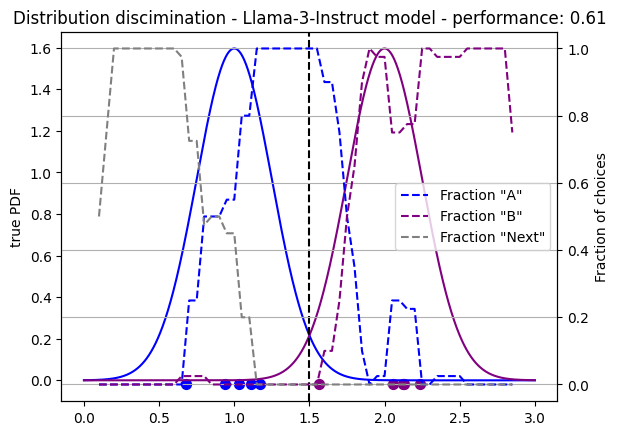

In [11]:
# convert the response fractions to numpy array
response_fractions_matrix = np.array(response_fractions)
# convert the testing samples to numpy array
testing_samples_vector = np.array(testing_samples)

# set number of rows
num_rows=response_fractions_matrix.shape[0]
# calculate the middle index
half_rows = num_rows // 2
# initialize a matrix of zeros with the same shape as the input
ideal_matrix = np.zeros((num_rows, 3))
# set the first half to [1, 0, 0]
ideal_matrix[:half_rows] = [1, 0, 0]
# Set the second half to [0, 1, 0]
ideal_matrix[half_rows:] = [0, 1, 0]
# compute performance metrics (fraction of correct responses)
performance = (response_fractions_matrix * ideal_matrix).sum(axis=1)     
# compute the average performance
average_performance = performance.mean()

# generating points for the Gaussian curves
x = np.linspace(0, 3, 1000)
gaussian_A = (1 / (dist_A['std'] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - dist_A['mean']) / dist_A['std'])**2)
gaussian_B = (1 / (dist_B['std'] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - dist_B['mean']) / dist_B['std'])**2)
# plotting the Gaussian curves
plt.plot(x, gaussian_A, label='Gaussian A', color='blue')
plt.plot(x, gaussian_B, label='Gaussian B', color='purple')
# plotting the samples
plt.scatter(samples_A, np.zeros_like(samples_A) - 0.02, color='blue', s=50, label='Samples A')
plt.scatter(samples_B, np.zeros_like(samples_B) - 0.02, color='purple', s=50, label='Samples B')
# plot dashed vertical line for ideal boundary
plt.axvline(x=1.5, color='black', linestyle='dashed')
plt.ylabel('true PDF')
# plotting the response fractions on another y-axis with dashed lines
plt.twinx()
plt.plot(testing_samples_vector, smooth_vector(response_fractions_matrix[:, 0],4), label='Fraction "A"', color='blue', linestyle='dashed')
plt.plot(testing_samples_vector, smooth_vector(response_fractions_matrix[:, 1],4), label='Fraction "B"', color='purple', linestyle='dashed')
plt.plot(testing_samples_vector, smooth_vector(response_fractions_matrix[:, 2],4), label='Fraction "Next"', color='gray', linestyle='dashed')
# adding labels and title
plt.xlabel('Value')
plt.ylabel('Fraction of choices')
plt.title('Distribution discimination - Llama-3-Instruct model - performance: {:.2f}'.format(average_performance))
plt.legend()
plt.grid(True)
# Show the plot
plt.show()
# NB: Interesting, model seems to be biased towards 'Next' response at low values but not high values. 
# Bias seems to be present for A over B. Experiment more with prompt, samples, temperature, and top_p.
# Get also bayesian baseline. ... could bias be due to attending mainly the first digit?

### Further textual interaction with the model (to be continued ...)

In [12]:
# set the system message
system_message = "You are the llama-3-Instruct model, a large language model trained to generate text.\
        Giulio is the name of the person who set me up on this PC. I will work as a subject of Giulio's research."
# set the plain message for prompt 1
plain_message="What do you know about signal detection theory?"
prompt_1=prepare_tokenized_prompt(plain_message, system_message, text_generator)
# batch the prompts
prompts=[prompt_1]
# generate the completions for the batched prompts
completions=generate_response(prompts)
# get the cleaned responses in plain text
clean_responses=get_clean_response(completions)
# print the cleaned responses
for clean_response in clean_responses:
    print("----------------------   Response   ----------------------")
    print_response(clean_response) 
print("----------------------------------------------------------")

----------------------   Response   ----------------------
A fascinating topic! Signal detection theory (SDT) is a statistical
framework used to analyze and model human decision-making in
situations where there is uncertainty or ambiguity. It's particularly
useful in understanding how people detect and respond to signals or
stimuli in various contexts, such as psychology, neuroscience, and
engineering.  In SDT, the theory posits that individuals make
decisions based on the relative strengths of two internal responses:
the "signal" (the true stimulus) and the "noise" (the random or
irrelevant information). The theory assumes that the signal and noise
are independent and identically distributed, and that the decision-
maker's response is a function of the relative strengths of these two
responses.  The core concepts in SDT are:  1. Hit rate (HR): The
proportion of times the signal is detected correctly. 2. False alarm
rate (FAR): The proportion of times noise is detected as a signal. 3.
